In [26]:
import pandas as pd

daily_por_tramo = pd.read_csv("daily_por_tramo_6_4.csv", index_col=0)

print("✅ Dataset cargado correctamente.")

✅ Dataset cargado correctamente.


In [ ]:
vars_ambientales = ['TA', 'HA', 'radiacion', 'precipitacion', 'eto']
vars_suelo       = ['HS10','HS20','HS30','HS40','HS50','HS6','TS30','litros_diarios']
VENTANA = 4

def build_windowed_df(df, vars_ambientales_base, vars_suelo_base, ventana=4):
    rows = []
    for i in range(1, len(df) - ventana):
        t = df.index[i]
        y = int(df.iloc[i + ventana]['CMNDT'] < 0) 
        feats = {'fecha': t, 'y': y}

        for base in vars_ambientales_base:
            cols = [c for c in df.columns if c.startswith(base)]
            for col in cols:
                for offset in range(-1, ventana + 1):
                    if offset < 0:
                        suffix = f"_t{offset}"
                    elif offset == 0:
                        suffix = "_t0"
                    else:
                        suffix = f"_t+{offset}"
                    colname = f"{col}{suffix}"
                    feats[colname] = df.iloc[i + offset][col]

        for base in vars_suelo_base:
            cols = [c for c in df.columns if c.startswith(base)]
            for col in cols:
                for offset in range(0, ventana + 1):
                    if offset == 0:
                        suffix = "_t0"
                    else:
                        suffix = f"_t+{offset}"
                    colname = f"{col}{suffix}"
                    feats[colname] = df.iloc[i + offset][col]

        rows.append(feats)

    return pd.DataFrame(rows).set_index('fecha')

df_src = daily_por_tramo.copy()

df_series = build_windowed_df(df_src, vars_ambientales, vars_suelo, VENTANA)

In [3]:
df_series

,y,TA_mean_t-1,TA_mean_t0,TA_mean_t+1,TA_mean_t+2,TA_mean_t+3,TA_mean_t+4,TA_max_t-1,TA_max_t0,TA_max_t+1,...,TS30_max_t0,TS30_max_t+1,TS30_max_t+2,TS30_max_t+3,TS30_max_t+4,litros_diarios_t0,litros_diarios_t+1,litros_diarios_t+2,litros_diarios_t+3,litros_diarios_t+4
fecha,,,,,,,,,,,,,,,,,,,,,
2023-04-02,0,21.22,17.74,13.94,13.65,12.92,12.97,26.45,23.83,21.26,...,20.00,19.56,19.06,18.68,18.43,24.000000,26.000000,0.000000,25.333333,26.666667
2023-04-03,1,17.74,13.94,13.65,12.92,12.97,13.56,23.83,21.26,20.37,...,19.56,19.06,18.68,18.43,18.12,26.000000,0.000000,25.333333,26.666667,0.000000
2023-04-04,0,13.94,13.65,12.92,12.97,13.56,15.49,21.26,20.37,19.76,...,19.06,18.68,18.43,18.12,18.06,0.000000,25.333333,26.666667,0.000000,27.333333
2023-04-05,0,13.65,12.92,12.97,13.56,15.49,16.04,20.37,19.76,20.50,...,18.68,18.43,18.12,18.06,18.62,25.333333,26.666667,0.000000,27.333333,28.000000
2023-04-06,1,12.92,12.97,13.56,15.49,16.04,16.23,19.76,20.50,22.13,...,18.43,18.12,18.06,18.62,18.81,26.666667,0.000000,27.333333,28.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-21,1,12.59,15.55,14.23,11.04,11.88,14.16,20.68,20.90,20.06,...,18.00,17.81,17.37,17.00,16.50,0.000000,14.333333,0.000000,15.333333,0.000000
2023-11-22,0,15.55,14.23,11.04,11.88,14.16,12.82,20.90,20.06,20.00,...,17.81,17.37,17.00,16.50,16.62,14.333333,0.000000,15.333333,0.000000,13.333333
2023-11-23,1,14.23,11.04,11.88,14.16,12.82,15.76,20.06,20.00,21.54,...,17.37,17.00,16.50,16.62,16.62,0.000000,15.333333,0.000000,13.333333,0.000000


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import random
import numpy as np

SEED = 7
random.seed(SEED)
np.random.seed(SEED)

X = df_series.drop(columns=['y'])
y = df_series['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=SEED
)

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    max_features=None,
    random_state=SEED
)
rf.fit(X_train, y_train)

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    colsample_bytree=1,
    learning_rate=0.1,
    max_depth=3,
    n_estimators=100,
    subsample=0.8,
    random_state=SEED
)
xgb.fit(X_train, y_train)

importances_rf  = rf.feature_importances_
importances_xgb = xgb.feature_importances_

df_imp = pd.DataFrame({
    'variable': X.columns,
    'importance_rf': importances_rf,
    'importance_xgb': importances_xgb
})
df_imp['mean_imp'] = df_imp[['importance_rf', 'importance_xgb']].mean(axis=1)

df_imp = df_imp.sort_values(by='mean_imp', ascending=False).reset_index(drop=True)

df_imp['cumulative_importance'] = df_imp['mean_imp'].cumsum()

umbral= 0.5
selected_vars = df_imp[df_imp['cumulative_importance'] <= umbral]['variable'].tolist()

print("Variables seleccionadas (80% acumulado):", selected_vars)
print("Total seleccionadas:", len(selected_vars))

Variables seleccionadas (80% acumulado): ['HS40_min_t+3', 'litros_diarios_t+3', 'HS10_mean_t+4', 'HS20_mean_t+4', 'HS40_mean_t+1', 'HS40_mean_t0', 'HS20_max_t+4', 'HS10_min_t+4', 'HS50_min_t+3', 'HS50_max_t+4', 'radiacion_t+4', 'litros_diarios_t+4', 'HS10_max_t+3', 'HS50_mean_t+4', 'HS40_max_t+4', 'HS40_min_t0', 'HS40_min_t+2', 'HS30_max_t+3', 'HS60_min_t+3']
Total seleccionadas: 19


In [19]:
df_imp.head(30)

,variable,importance_rf,importance_xgb,mean_imp,cumulative_importance
0,HS40_min_t+3,0.111190,0.032593,0.071892,0.071892
1,litros_diarios_t+3,0.080849,0.017044,0.048946,0.120838
2,HS10_mean_t+4,0.075187,0.021036,0.048111,0.168950
3,HS20_mean_t+4,0.055679,0.026998,0.041339,0.210288
4,HS40_mean_t+1,0.015066,0.055262,0.035164,0.245452
5,HS40_mean_t0,0.035754,0.023460,0.029607,0.275059
6,HS20_max_t+4,0.041682,0.013984,0.027833,0.302892
7,HS10_min_t+4,0.015313,0.025209,0.020261,0.323153
8,HS50_min_t+3,0.015976,0.022522,0.019249,0.342402
9,HS50_max_t+4,0.012499,0.024581,0.018540,0.360942


In [ ]:
import matplotlib.pyplot as plt

df_imp = df_imp.sort_values('mean_imp', ascending=False).reset_index(drop=True)
df_imp['cumulative'] = df_imp['mean_imp'].cumsum()

df_plot = df_imp.iloc[:50].copy()

fig, ax1 = plt.subplots(figsize=(15, 6), dpi=1000)

color_bar = 'tab:blue'
ax1.bar(df_plot['variable'], df_plot['mean_imp'], color=color_bar, alpha=0.7)
ax1.set_ylabel('Importancia media', color=color_bar, fontsize=13)
ax1.set_xlabel('Variable', fontsize=13)
ax1.tick_params(axis='y', labelcolor=color_bar, labelsize=11)
ax1.tick_params(axis='x', labelsize=10)
ax1.set_xticks(range(len(df_plot)))
ax1.set_xticklabels(df_plot['variable'], rotation=45, ha='right', fontsize=10)
ax1.set_ylim(0, 0.10) 

ax2 = ax1.twinx()
color_line = 'tab:orange'
ax2.plot(df_plot['variable'], df_plot['cumulative'], color=color_line, marker='o', label='Importancia acumulada')
ax2.axhline(y=umbral, color='red', linestyle='--', label=f'Umbral {umbral * 100}%')
ax2.set_ylabel('Importancia acumulada', color=color_line, fontsize=13)
ax2.tick_params(axis='y', labelcolor=color_line, labelsize=11)
ax2.set_ylim(0, 1) 
ax2.legend(loc='upper center', fontsize=11)

plt.tight_layout()
plt.show()

In [28]:
# Filtrar train y test 
X_train_sel = X_train[selected_vars]
X_test_sel  = X_test[selected_vars]

No path specified. Models will be saved in: "AutogluonModels\ag-20250625_235400"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.0
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       16.72 GB / 31.82 GB (52.6%)
Disk Space Avail:   435.90 GB / 943.04 GB (46.2%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdo

F1 Score test: 0.833


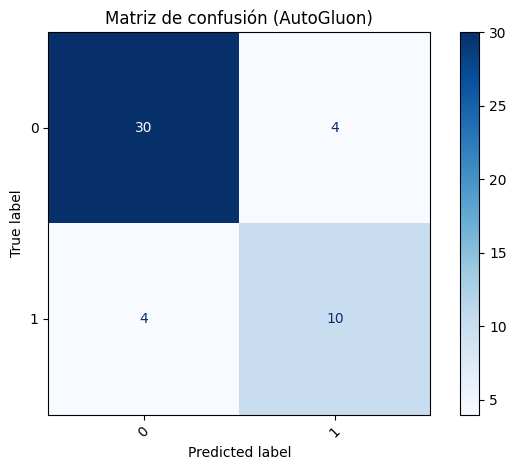

In [ ]:
from autogluon.tabular import TabularPredictor
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

train_data = X_train_sel.copy()
train_data['target'] = y_train

test_data  = X_test_sel.copy()
test_data['target'] = y_test

predictor = TabularPredictor(
    label='target',
    eval_metric='f1_weighted'
).fit(
    train_data,
    time_limit=180,   
    presets='best_quality', 
    verbosity=2
)

y_pred = predictor.predict(test_data)

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score test: {f1:.3f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de confusión (AutoGluon)")
plt.tight_layout()
plt.show()

y_prob_train = predictor.predict_proba(train_data)
y_prob_test  = predictor.predict_proba(test_data)

F1 con decisión coste-sensitiva: 0.761


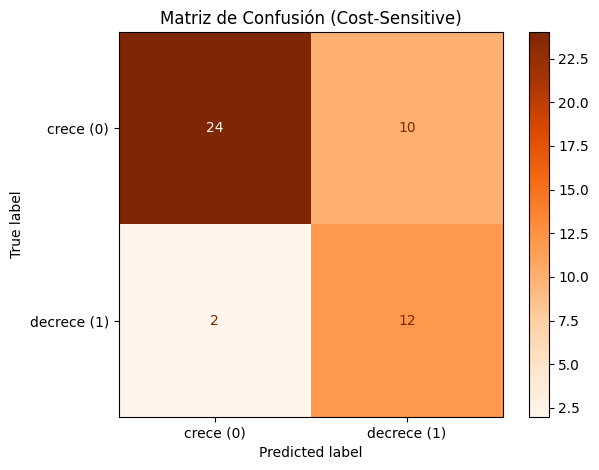

In [ ]:
C = np.array([
    [ 0,  5],   # real=0 → (0→0)=0, (0→1)=1
    [15,  0],   # real=1 → (1→0)=10,(1→1)=0
])

y_prob_test = predictor.predict_proba(test_data)

probs = y_prob_test.values

#    cost_expected[i,j] = sum_k p_i[k] * C[k,j]
cost_expected = probs.dot(C)

y_pred_cost = np.argmin(cost_expected, axis=1)

y_true = test_data['target'].values
f1_cost = f1_score(y_true, y_pred_cost, average='weighted')
print(f"F1 con decisión coste-sensitiva: {f1_cost:.3f}")

cm = confusion_matrix(y_true, y_pred_cost, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=['crece (0)','decrece (1)'])
disp.plot(cmap='Oranges', xticks_rotation=0)
plt.title("Matriz de Confusión (Cost-Sensitive)")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

print("\nResumen completo de métricas:")
print(classification_report(y_true, y_pred, digits=3, target_names=['crece (0)', 'decrece (1)']))


Resumen completo de métricas:
              precision    recall  f1-score   support

   crece (0)      0.882     0.882     0.882        34
 decrece (1)      0.714     0.714     0.714        14

    accuracy                          0.833        48
   macro avg      0.798     0.798     0.798        48
weighted avg      0.833     0.833     0.833        48



In [ ]:
from pathlib import Path
import pickle

base_path = Path(predictor.path) / "models" / "LightGBM_BAG_L1" / "S1F1" / "model.pkl"

with open(base_path, "rb") as f:
    fold_model = pickle.load(f)

booster = fold_model.model

print("📌 Hiperparámetros reales de LightGBM_BAG_L1 (fold 1):")
for key, value in booster.params.items():
    print(f"{key}: {value}")




📌 Hiperparámetros reales de LightGBM_BAG_L1 (fold 1):
learning_rate: 0.05
num_threads: 2
objective: binary
verbose: -1
seed: 0
num_iterations: 10000


  0%|          | 0/6 [00:00<?, ?it/s]

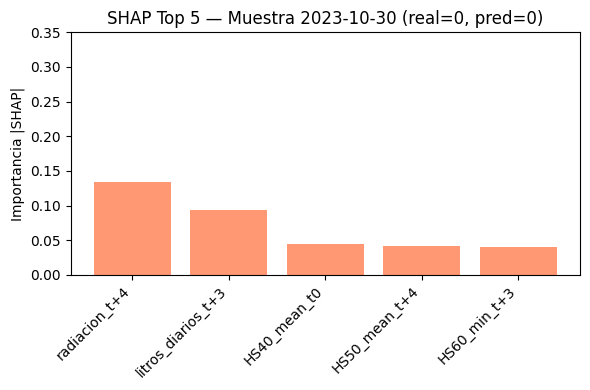

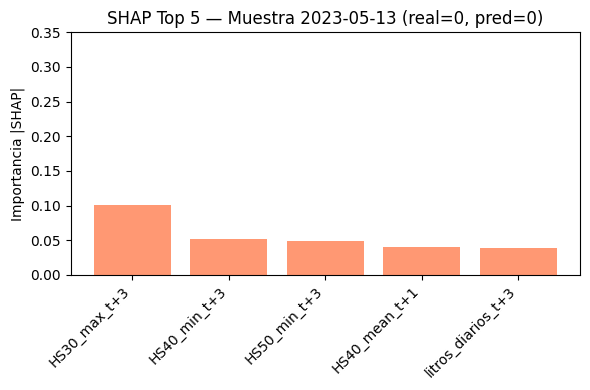

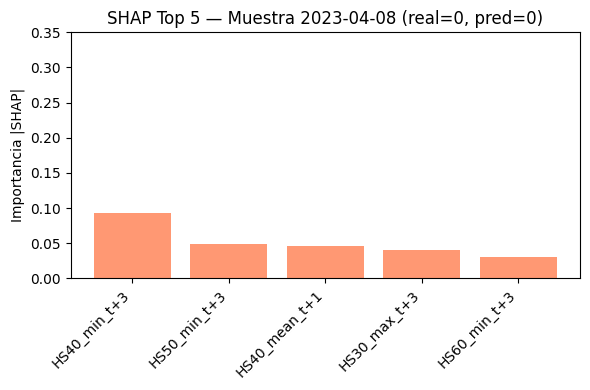

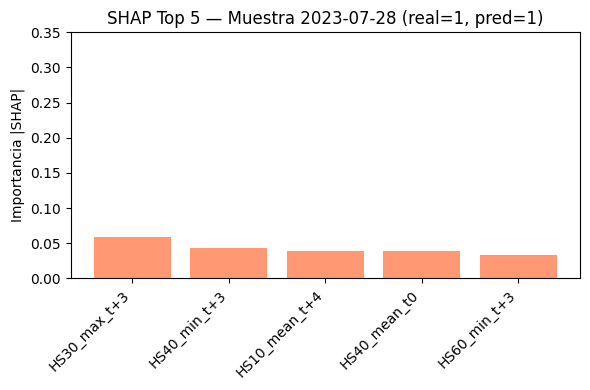

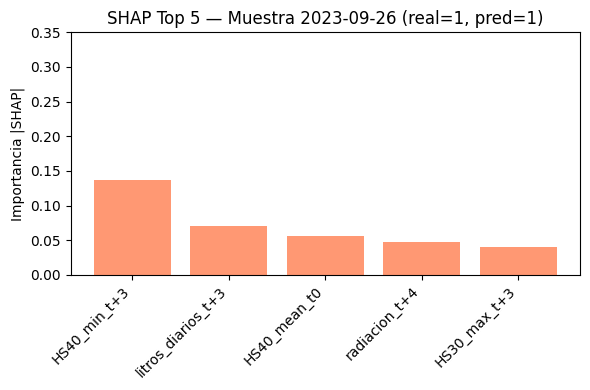

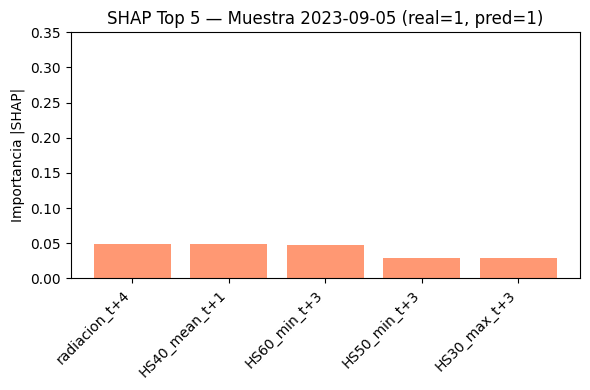

In [ ]:
from autogluon.tabular import TabularPredictor
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

predictor_path = r"c:\Users\usuario\Desktop\TFG\predicciones\AutogluonModels\ag-20250625_113742"
predictor = TabularPredictor.load(predictor_path)

X_shap = X_test.copy()
y_true = y_test.copy()
y_pred = predictor.predict(X_test)

idx_crece   = X_shap[(y_true == 0) & (y_pred == 0)].index[:3]
idx_decrece = X_shap[(y_true == 1) & (y_pred == 1)].index[:3]
selected_idx = list(idx_crece) + list(idx_decrece)

def predict_fn(X_array):
    X_df = pd.DataFrame(X_array, columns=X_shap.columns)
    return predictor.predict_proba(X_df).values

X_background = X_shap.loc[selected_idx]
explainer = shap.KernelExplainer(predict_fn, X_background)

X_explain   = X_shap.loc[selected_idx]
shap_values = explainer.shap_values(X_explain) 

feature_names = X_shap.columns
top_n = 5

for i, idx in enumerate(selected_idx):
    true_cls = int(y_true.loc[idx])
    pred_cls = int(y_pred[idx])
    vals     = shap_values[pred_cls][i]
    abs_vals = np.abs(vals)
    
    top_idx   = np.argsort(abs_vals)[-top_n:][::-1]
    top_feats = feature_names[top_idx]
    top_vals  = abs_vals[top_idx]
    
    plt.figure(figsize=(6,4))
    plt.bar(top_feats, top_vals, color='coral', alpha=0.8)
    plt.title(f"SHAP Top {top_n} — Muestra {idx} (real={true_cls}, pred={pred_cls})")
    plt.ylabel("Importancia |SHAP|")
    plt.ylim(0, 0.35)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
import dice_ml
from dice_ml import Dice

df_dice = X_train_sel.copy()
df_dice['y'] = y_train

continuous = [c for c in df_dice.columns if c != 'y']

# Variables que el agricultor puede modificar (edáficas)
controllable_prefixes = ['HS10','HS20','HS30','HS40','HS50','HS60','TS30']
features_to_vary = [c for c in df_dice.columns if any(c.startswith(pref) for pref in controllable_prefixes)]

data_interface = dice_ml.Data(
    dataframe=df_dice,
    continuous_features=continuous,
    outcome_name='y'
)

class AutoGluonWrapper:
    def __init__(self, predictor):
        self.predictor = predictor
    def predict_proba(self, X):
        X = X[self.predictor.feature_metadata.get_features()]
        preds = self.predictor.predict_proba(X)
        if isinstance(preds, pd.Series):
            arr = np.column_stack([1-preds.values, preds.values])
        elif isinstance(preds, pd.DataFrame):
            if {0,1}.issubset(preds.columns):
                arr = preds[[0,1]].values
            else:
                arr = preds.values
        else:
            arr = np.array(preds)
        return arr.astype(np.float64)

model_interface = dice_ml.Model(
    model=AutoGluonWrapper(predictor),
    backend="sklearn"
)

exp = Dice(
    data_interface=data_interface,
    model_interface=model_interface,
    method="random"
)

mask = (y_test==1) & (predictor.predict(X_test_sel)==1)
idx = np.where(mask)[0][0]  # primer índice válido
X_query = X_test_sel.iloc[[idx]].reset_index(drop=True)

cf = exp.generate_counterfactuals(
    X_query,
    total_CFs=3,
    desired_class=0,
    features_to_vary=features_to_vary,
    random_seed=7
)

cf.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:04<00:00,  4.67s/it]

Query instance (original outcome : 1)


,HS40_min_t+3,litros_diarios_t+3,HS10_mean_t+4,HS20_mean_t+4,HS40_mean_t+1,HS40_mean_t0,HS20_max_t+4,HS10_min_t+4,HS50_min_t+3,HS50_max_t+4,radiacion_t+4,litros_diarios_t+4,HS10_max_t+3,HS50_mean_t+4,HS40_max_t+4,HS40_min_t0,HS40_min_t+2,HS30_max_t+3,HS60_min_t+3,y
0,0.8003,33.333332,0.600632,0.644311,0.84112,0.839628,0.8624,0.5449,0.805,0.8112,26.43,34.666668,0.8472,0.808894,0.9672,0.7931,0.7926,0.9212,0.7674,1



Diverse Counterfactual set (new outcome: 0)


,HS40_min_t+3,litros_diarios_t+3,HS10_mean_t+4,HS20_mean_t+4,HS40_mean_t+1,HS40_mean_t0,HS20_max_t+4,HS10_min_t+4,HS50_min_t+3,HS50_max_t+4,radiacion_t+4,litros_diarios_t+4,HS10_max_t+3,HS50_mean_t+4,HS40_max_t+4,HS40_min_t0,HS40_min_t+2,HS30_max_t+3,HS60_min_t+3,y
0,-,-,-,-,-,-,-,-,0.6974,-,-,-,-,-,-,-,-,-,0.7152,0.0
1,-,-,-,-,-,0.77457781,0.6797,-,-,-,-,-,-,-,-,-,-,-,-,0.0
2,-,-,-,-,-,-,0.601,-,0.6797,-,-,-,-,-,-,-,-,-,-,0.0


In [ ]:
# Ejemplos bien clasificados como 'decrece' (y = 1)
mask = (y_test == 1) & (predictor.predict(X_test_sel) == 1)
positions = np.where(mask)[0]

print(f"Se encontraron {len(positions)} ejemplos bien clasificados como 'decrece'.")

# 5 ejemplos
for i, idx in enumerate(positions[:5]):
    print(f"\n📌 Ejemplo {i+1} en la posición {idx}:")

    X_query = X_test_sel.iloc[[idx]].reset_index(drop=True)

    cf = exp.generate_counterfactuals(
        X_query,
        total_CFs=3,
        desired_class=0,
        features_to_vary=features_to_vary
    )

    display(cf.visualize_as_dataframe(show_only_changes=True))

Se encontraron 10 ejemplos bien clasificados como 'decrece'.

📌 Ejemplo 1 en la posición 4:


100%|██████████| 1/1 [00:04<00:00,  4.83s/it]

Query instance (original outcome : 1)


,HS40_min_t+3,litros_diarios_t+3,HS10_mean_t+4,HS20_mean_t+4,HS40_mean_t+1,HS40_mean_t0,HS20_max_t+4,HS10_min_t+4,HS50_min_t+3,HS50_max_t+4,radiacion_t+4,litros_diarios_t+4,HS10_max_t+3,HS50_mean_t+4,HS40_max_t+4,HS40_min_t0,HS40_min_t+2,HS30_max_t+3,HS60_min_t+3,y
0,0.8003,33.333332,0.600632,0.644311,0.84112,0.839628,0.8624,0.5449,0.805,0.8112,26.43,34.666668,0.8472,0.808894,0.9672,0.7931,0.7926,0.9212,0.7674,1



Diverse Counterfactual set (new outcome: 0)


,HS40_min_t+3,litros_diarios_t+3,HS10_mean_t+4,HS20_mean_t+4,HS40_mean_t+1,HS40_mean_t0,HS20_max_t+4,HS10_min_t+4,HS50_min_t+3,HS50_max_t+4,radiacion_t+4,litros_diarios_t+4,HS10_max_t+3,HS50_mean_t+4,HS40_max_t+4,HS40_min_t0,HS40_min_t+2,HS30_max_t+3,HS60_min_t+3,y
0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.7615,-,0.0
1,0.6607,-,-,-,-,-,-,-,-,-,-,-,0.789,-,-,-,-,-,-,0.0
2,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.8085,-,-,0.7946,-,0.0


None


📌 Ejemplo 2 en la posición 5:


100%|██████████| 1/1 [00:04<00:00,  4.78s/it]

Query instance (original outcome : 1)


,HS40_min_t+3,litros_diarios_t+3,HS10_mean_t+4,HS20_mean_t+4,HS40_mean_t+1,HS40_mean_t0,HS20_max_t+4,HS10_min_t+4,HS50_min_t+3,HS50_max_t+4,radiacion_t+4,litros_diarios_t+4,HS10_max_t+3,HS50_mean_t+4,HS40_max_t+4,HS40_min_t0,HS40_min_t+2,HS30_max_t+3,HS60_min_t+3,y
0,0.8413,20.666666,0.656852,0.686752,0.875087,0.804249,0.8551,0.5534,0.8243,0.8343,19.389999,49.333332,0.8189,0.826262,0.9499,0.7703,0.7778,0.9072,0.7999,1



Diverse Counterfactual set (new outcome: 0)


,HS40_min_t+3,litros_diarios_t+3,HS10_mean_t+4,HS20_mean_t+4,HS40_mean_t+1,HS40_mean_t0,HS20_max_t+4,HS10_min_t+4,HS50_min_t+3,HS50_max_t+4,radiacion_t+4,litros_diarios_t+4,HS10_max_t+3,HS50_mean_t+4,HS40_max_t+4,HS40_min_t0,HS40_min_t+2,HS30_max_t+3,HS60_min_t+3,y
0,0.6974,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.9192,-,-,-,0.0
1,0.7642,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0
2,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.7092,-,0.0


None


📌 Ejemplo 3 en la posición 13:


100%|██████████| 1/1 [00:05<00:00,  5.08s/it]

Query instance (original outcome : 1)


,HS40_min_t+3,litros_diarios_t+3,HS10_mean_t+4,HS20_mean_t+4,HS40_mean_t+1,HS40_mean_t0,HS20_max_t+4,HS10_min_t+4,HS50_min_t+3,HS50_max_t+4,radiacion_t+4,litros_diarios_t+4,HS10_max_t+3,HS50_mean_t+4,HS40_max_t+4,HS40_min_t0,HS40_min_t+2,HS30_max_t+3,HS60_min_t+3,y
0,0.7505,23.333334,0.595479,0.637851,0.876385,0.823655,0.8542,0.5456,0.8274,0.8274,21.030001,24.333334,0.8254,0.815624,0.8079,0.7784,0.7793,0.8845,0.8332,1



Diverse Counterfactual set (new outcome: 0)


,HS40_min_t+3,litros_diarios_t+3,HS10_mean_t+4,HS20_mean_t+4,HS40_mean_t+1,HS40_mean_t0,HS20_max_t+4,HS10_min_t+4,HS50_min_t+3,HS50_max_t+4,radiacion_t+4,litros_diarios_t+4,HS10_max_t+3,HS50_mean_t+4,HS40_max_t+4,HS40_min_t0,HS40_min_t+2,HS30_max_t+3,HS60_min_t+3,y
0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.7414,0.8568,0.0
1,0.744,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.7994,-,0.0
2,-,-,-,-,-,0.90062865,-,-,-,-,-,-,-,-,-,-,-,0.676,-,0.0


None


📌 Ejemplo 4 en la posición 18:


100%|██████████| 1/1 [00:04<00:00,  5.00s/it]

Query instance (original outcome : 1)


,HS40_min_t+3,litros_diarios_t+3,HS10_mean_t+4,HS20_mean_t+4,HS40_mean_t+1,HS40_mean_t0,HS20_max_t+4,HS10_min_t+4,HS50_min_t+3,HS50_max_t+4,radiacion_t+4,litros_diarios_t+4,HS10_max_t+3,HS50_mean_t+4,HS40_max_t+4,HS40_min_t0,HS40_min_t+2,HS30_max_t+3,HS60_min_t+3,y
0,0.7417,28.0,0.532736,0.577929,0.721054,0.789429,0.6115,0.5083,0.7306,0.8108,22.68,0.0,0.8002,0.781579,0.763,0.7641,0.6643,0.8432,0.747,1



Diverse Counterfactual set (new outcome: 0)


,HS40_min_t+3,litros_diarios_t+3,HS10_mean_t+4,HS20_mean_t+4,HS40_mean_t+1,HS40_mean_t0,HS20_max_t+4,HS10_min_t+4,HS50_min_t+3,HS50_max_t+4,radiacion_t+4,litros_diarios_t+4,HS10_max_t+3,HS50_mean_t+4,HS40_max_t+4,HS40_min_t0,HS40_min_t+2,HS30_max_t+3,HS60_min_t+3,y
0,-,-,-,-,-,-,-,-,-,-,-,-,0.541,-,-,-,-,-,-,0.0
1,-,-,-,0.67048591,-,-,0.8432,-,-,-,-,-,-,-,-,-,-,-,-,0.0
2,-,-,-,-,-,-,-,-,-,-,-,-,0.673,-,-,-,-,-,0.7871,0.0


None


📌 Ejemplo 5 en la posición 26:


100%|██████████| 1/1 [00:04<00:00,  4.79s/it]

Query instance (original outcome : 1)


,HS40_min_t+3,litros_diarios_t+3,HS10_mean_t+4,HS20_mean_t+4,HS40_mean_t+1,HS40_mean_t0,HS20_max_t+4,HS10_min_t+4,HS50_min_t+3,HS50_max_t+4,radiacion_t+4,litros_diarios_t+4,HS10_max_t+3,HS50_mean_t+4,HS40_max_t+4,HS40_min_t0,HS40_min_t+2,HS30_max_t+3,HS60_min_t+3,y
0,0.7494,23.333334,0.651612,0.679521,0.721465,0.812587,0.8481,0.5485,0.7821,0.8,20.440001,54.333332,0.8164,0.78477,0.9219,0.7495,0.6955,0.8898,0.809,1



Diverse Counterfactual set (new outcome: 0)


,HS40_min_t+3,litros_diarios_t+3,HS10_mean_t+4,HS20_mean_t+4,HS40_mean_t+1,HS40_mean_t0,HS20_max_t+4,HS10_min_t+4,HS50_min_t+3,HS50_max_t+4,radiacion_t+4,litros_diarios_t+4,HS10_max_t+3,HS50_mean_t+4,HS40_max_t+4,HS40_min_t0,HS40_min_t+2,HS30_max_t+3,HS60_min_t+3,y
0,-,-,-,-,-,0.89454226,-,-,0.7062,-,-,-,-,-,-,-,-,-,-,0.0
1,-,-,-,-,-,-,-,0.5051,-,-,-,-,-,-,-,0.8479,-,-,-,0.0
2,-,-,-,-,-,-,-,-,-,0.728,-,-,-,0.9188565,-,-,-,-,-,0.0


None